In [1]:
import numpy as np
import pandas as pd
import os

We have a problem regarding calculating player similarity. Games have different lengths and different amounts of players, it's not possible to compare them if they have irregular formats. Hence we are going to create embeddings for each player rich in information to "sumarize" their behaviour with other players and during the game.

In [2]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
max_rows = 0
max_columns = 0
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    max_rows = max(max_rows, game.shape[0])
    max_columns = max(max_columns, data.NUMBER_OF_PARTICIPANTS * 2 - 1)
max_rows, max_columns

(10710, np.int64(15))

We will fill the lack of information (due to a game being shorter or having less people) with zeros.

In [3]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
rows = []
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    inter_player_columns = game.columns[game.columns.str.match(f'P._TO_P.')]
    interaction_players = game[inter_player_columns].mean().mean()
    for id in range(1, data.NUMBER_OF_PARTICIPANTS+1):
        p1_looks = game.columns[game.columns.str.match(f'P{id}_TO_.[^{id}]')]
        p1_looked = game.columns[game.columns.str.match(f'P[^{id}]_TO_P{id}')]
        unpadded = game[[*p1_looks, *p1_looked]].values

        padded_array = np.zeros((max_rows, max_columns))
        padded_array[:unpadded.shape[0], :unpadded.shape[1]] = unpadded
        row = padded_array.flatten()
        
        rows.append(row)
        
df = pd.DataFrame(rows)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,160640,160641,160642,160643,160644,160645,160646,160647,160648,160649
0,0.534,0.046,0.083,0.000,0.041,0.029,0.067,0.023,0.030,0.049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.077,0.023,0.127,0.011,0.025,0.034,0.503,0.046,0.041,0.019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.079,0.030,0.041,0.039,0.041,0.037,0.533,0.083,0.127,0.063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100,0.049,0.019,0.063,0.073,0.377,0.120,0.000,0.011,0.039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043,0.034,0.040,0.357,0.020,0.050,0.256,0.041,0.025,0.041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,0.023,0.047,0.096,0.021,0.313,0.244,0.027,0.029,0.014,0.063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.083,0.070,0.109,0.080,0.057,0.177,0.074,0.150,0.246,0.499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448,0.037,0.039,0.031,0.066,0.126,0.374,0.053,0.074,0.056,0.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,0.004,0.048,0.079,0.049,0.024,0.059,0.519,0.019,0.064,0.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we create the model that will generate the embeddings.

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(max_rows * max_columns,))

# Encoder
encoded = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(encoded)

# Embedding Layer
embedding = Dense(16, activation='relu', name='embedding')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(embedding)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(max_rows * max_columns, activation='linear')(decoded)

# Split into encoder and autoencoder models
autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=embedding)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    df.values,
    df.values, 
    epochs=100, 
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Now we can use the encoder to generate embeddings for players
player_embeddings = encoder.predict(df.values)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160650)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    10,281,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 160650)         │    10,442,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,729,562 (79.08 MB)

 Trainable params: 20,729,370 (79.08 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.1347 - val_loss: 0.0776
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0796 - val_loss: 0.0920
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0779 - val_loss: 0.0676
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0649 - val_loss: 0.0582
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0563 - val_loss: 0.0518
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0507 - val_loss: 0.0485
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0470 - val_loss: 0.0439
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0424 - val_loss: 0.0432
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0398 - val_loss: 0.0419
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0396 - val_loss: 0.0420
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0393 - val_loss: 0.0374
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1

In [6]:
player_embeddings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08894651],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09501833],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

<Axes: ylabel='Frequency'>

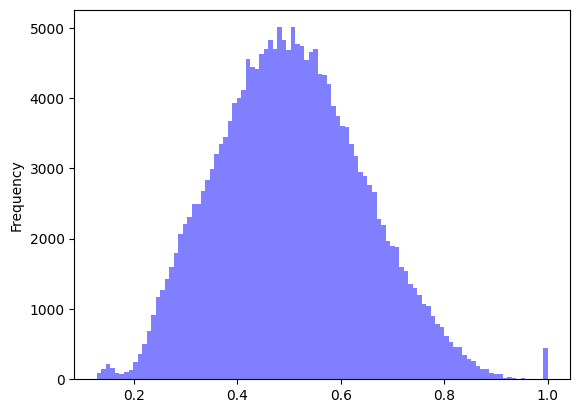

In [38]:
from scipy.spatial.distance import pdist,squareform
distances = squareform(pdist(player_embeddings, metric='euclidean'))
q = 0.5 # Adjust such that half of the similarities are under 0.5
similarities = 1/(1+distances*(q**-1 - 1)/np.quantile(distances, q))
pd.Series(similarities.flatten()).plot.hist(bins=100, alpha=0.5, color='blue', label='Euclidean') 
# Tiene buena pinta

In [39]:
# Quitamos similitudes con uno mismo
similarities[np.eye(similarities.shape[0], dtype=bool)] = 0
similarities

array([[0.        , 0.68874613, 0.2397075 , ..., 0.39551907, 0.54481545,
        0.43942472],
       [0.68874613, 0.        , 0.26706533, ..., 0.44838322, 0.54811712,
        0.49186361],
       [0.2397075 , 0.26706533, 0.        , ..., 0.31125823, 0.24519512,
        0.28465134],
       ...,
       [0.39551907, 0.44838322, 0.31125823, ..., 0.        , 0.4968819 ,
        0.73982486],
       [0.54481545, 0.54811712, 0.24519512, ..., 0.4968819 , 0.        ,
        0.5983778 ],
       [0.43942472, 0.49186361, 0.28465134, ..., 0.73982486, 0.5983778 ,
        0.        ]])

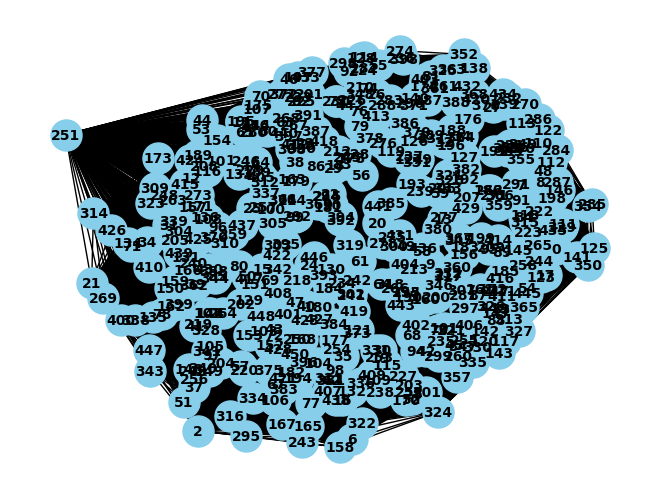

In [40]:
import networkx as nx
G = nx.Graph(similarities)
nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')

In [41]:
nx.write_gml(G, 'comm-f2f-Resistance/embeddings.gml')